In [1]:
# Installing and upgrading the scikit-network package
!pip install --user scikit-network
!pip install --user --upgrade scikit-network

# Importing the necessary libraries for the project
from sknetwork.ranking import PageRank
from scipy import stats

import sknetwork.topology as topology_module
import inspect
import numpy as np
import pandas as pd
import copy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
# Downloading the Comedy_IMDB dataset from Google Drive
!gdown --id 1Xu8EeWQZFkPe-1EvqMpkkMMg09Mgy07_

C:\Users\dahal\anaconda3\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Xu8EeWQZFkPe-1EvqMpkkMMg09Mgy07_
To: C:\Users\dahal\Comedy_IMDB.csv

  0%|          | 0.00/1.77M [00:00<?, ?B/s]
 30%|##9       | 524k/1.77M [00:00<00:00, 3.79MB/s]
100%|##########| 1.77M/1.77M [00:00<00:00, 8.50MB/s]


In [4]:
#Loading the IMDB movies dataset from the 'Comedy_IMDB.csv' file to a Pandas dataframe
IMDB_movies_graph = pd.read_csv('Comedy_IMDB.csv')

# Extracting the field names from the dataset and displaying them in a nice format
dataset_field = list(IMDB_movies_graph.columns)
nice_print = pd.DataFrame( dataset_field )
nice_print.rename(columns = {0: 'IMDB Movie dataset Field names'}, inplace = True)
print(nice_print)
print()

# Displaying the number of rows in the dataset
print("The number of row of the dataset are: ", IMDB_movies_graph.shape[0])
print()

# Considering only first 100 rows of the dataset for analysis
IMDB_movies_graph = IMDB_movies_graph.head(100)

# Displaying the first row conetnts from reduced dataset
print(f"First row:\n{IMDB_movies_graph.iloc[0]}")
print()

# Displaying the last row conetnts from reduced dataset
print(f"Last row:\n{IMDB_movies_graph.iloc[-1]}")

  IMDB Movie dataset Field names
0                             SN
1                          Movie
2                          Genre
3                        Runtime
4                    Certificate
5                         Rating
6                           Cast
7                    Description
8                          Votes
9                       Director

The number of row of the dataset are:  5294

First row:
SN                                                             1
Movie                                         They Cloned Tyrone
Genre                        Action, Comedy, Mystery            
Runtime                                                  122 min
Certificate                                                    R
Rating                                                       6.7
Cast           ['John Boyega, ', 'Jamie Foxx, ', 'Teyonah Par...
Description    A series of eerie events thrusts an unlikely t...
Votes                                                     14

In [5]:
print(IMDB_movies_graph.columns)

Index(['SN', 'Movie', 'Genre', 'Runtime', 'Certificate', 'Rating', 'Cast',
       'Description', 'Votes', 'Director'],
      dtype='object')


In [6]:
nice_print

,IMDB Movie dataset Field names
0,SN
1,Movie
2,Genre
3,Runtime
4,Certificate
5,Rating
6,Cast
7,Description
8,Votes
9,Director


In [7]:
# Creating a deep copy of the IMDB_movies_graph DataFrame and storing it in 'ddf'
ddf = copy.deepcopy(IMDB_movies_graph)

# Removing commas and spaces from string-type columns in 'ddf'
ddf = ddf.apply(lambda x: x.replace(',', '').replace(' ', '') if x.dtype == 'O' else x)

# Converting 'Genre', 'Cast', and 'Director' columns to appropriate data structures
# Splitting the 'Cast' column by commas and cleaning up the names

ddf['Cast'] = ddf['Cast'].apply(lambda x: [name.strip(', ') for name in eval(x)])

# Exploding the 'Cast' column to separate individual cast members into rows
ddf = ddf.explode('Cast')

# Cleaning up the 'Director' column, removing empty strings and joining director names
ddf['Director'] = ddf['Director'].apply(lambda x: " ".join([director for director in eval(x) if x != ""]).strip(", "))

# Creating a new column 'Person' combining 'Director' and 'Cast' for each row
ddf['Person'] = ddf.apply(lambda row: [row['Director'], row['Cast']], axis=1)

# Exploding the 'Person' column to separate individuals into rows
ddf = ddf.explode('Person')

# Setting 'Genre' as the index for 'ddf' and retrieving its data type
index_name = 'Genre'
dtype_of_index = ddf[index_name].dtype

# Displaying the updated DataFrame 'ddf' and the data type of the 'Genre' index
ddf,dtype_of_index

(     SN               Movie                                Genre  Runtime  \
 0     1  They Cloned Tyrone  Action, Comedy, Mystery              122 min   
 0     1  They Cloned Tyrone  Action, Comedy, Mystery              122 min   
 0     1  They Cloned Tyrone  Action, Comedy, Mystery              122 min   
 0     1  They Cloned Tyrone  Action, Comedy, Mystery              122 min   
 0     1  They Cloned Tyrone  Action, Comedy, Mystery              122 min   
 ..  ...                 ...                                  ...      ...   
 99  100  The Last Boy Scout    Action, Comedy, Crime              105 min   
 99  100  The Last Boy Scout    Action, Comedy, Crime              105 min   
 99  100  The Last Boy Scout    Action, Comedy, Crime              105 min   
 99  100  The Last Boy Scout    Action, Comedy, Crime              105 min   
 99  100  The Last Boy Scout    Action, Comedy, Crime              105 min   
 
    Certificate  Rating             Cast  \
 0            R   

In [8]:
# Extracting unique values for specific columns in the DataFrame 'ddf'
# unique_genres = ddf['Genre'].explode().unique()
unique_movies = ddf['Movie'].unique()
unique_director = ddf['Director'].unique()
unique_rating = ddf['Rating'].unique()

# Displaying the count of unique values for different columns
print(f'Unique Movies: {len(unique_movies)}')
print(f'Unique Director: {len(unique_director)}')
print(f'Unique Rating: {len(unique_rating)}')

Unique Movies: 99
Unique Director: 100
Unique Rating: 36


In [9]:
# Creating a deep copy of the DataFrame 'ddf' and store it in the variable 'df'
df = copy.deepcopy(ddf)

# Constructing a bipartite graph
G = nx.Graph()

# Adding nodes and edges to the graph
for _, row in df.iterrows():
    G.add_node(row['Movie'], bipartite=0)  # Movie nodes
    G.add_node(row['Person'], bipartite=1)  # Director and cast nodes
    G.add_node(row['Rating'], bipartite=1)  # Rating nodes
    G.add_node(row['Genre'], bipartite=1)   # Genre nodes

    G.add_edge(row['Movie'], row['Person'])
    G.add_edge(row['Movie'], row['Rating'])
    G.add_edge(row['Movie'], row['Genre'])

# Adding ratings to the graph
rating_data = {
    'Movie': [],
    'Rating': []
}
for _, row in df.iterrows():
    rating_data['Movie'].append(row['Movie'])
    rating_data['Rating'].append(row['Rating'])
    G.nodes[row['Rating']]['bipartite'] = 1  # Set the bipartite attribute for rating nodes

# Displaying ratings
print("Movie Ratings:")
rating_df = pd.DataFrame(rating_data)
rating_df = rating_df.sort_values(by='Rating', ascending=False)
display(rating_df)

# Calculating PageRank scores with the updated graph
pagerank_scores = nx.pagerank(G)

# Displaying PageRank scores
print("\nPageRank Scores for Movies:")
score_data = {
    'Movie': [],
    'Score': []
}

# Iterating through the pagerank_scores dictionary, sorting by score in descending order
for node, score in sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True):
    # Checking if the node is a movie (assuming 'bipartite' attribute distinguishes movie nodes)
    if G.nodes[node]['bipartite'] == 0:
        score_data['Movie'].append(node)
        score_data['Score'].append(score)

# Creating a DataFrame 'score_df' using the collected movie nodes and their scores
score_df = pd.DataFrame(score_data)

# Sorting the DataFrame by 'Score' column in descending order
score_df = score_df.sort_values(by='Score', ascending=False)

# Displaying the DataFrame showing movies and their respective scores
display(score_df)


Movie Ratings:


,Movie,Rating
589,One Punch Man: Wanpanman,8.7
11,The Boys,8.7
19,The Boys,8.7
18,The Boys,8.7
17,The Boys,8.7
...,...,...
573,Peter Pan & Wendy,4.4
572,Peter Pan & Wendy,4.4
571,Peter Pan & Wendy,4.4
570,Peter Pan & Wendy,4.4



PageRank Scores for Movies:


,Movie,Score
0,Teenage Mutant Ninja Turtles,0.008882
1,Archer,0.005509
2,Pixels,0.005427
3,Ready or Not,0.005316
4,Barry,0.005283
...,...,...
94,Deadpool 2,0.004306
95,Ant-Man,0.004262
96,Game Night,0.004242
97,Guardians of the Galaxy Vol. 2,0.004078


In [10]:
# Merging two DataFrames 'score_df' and 'rating_df' based on the 'Movie' column
merged_df = pd.merge(score_df, rating_df, on='Movie')

# Taking sample weights
weights = [
    {'score': 0.1, 'rating': 0.9},   
    {'score': 0.5, 'rating': 0.5},
    {'score': 0.7, 'rating': 0.3},   
    {'score': 0.9, 'rating': 0.1}
]

# Function to calculate combined score
def calculate_score(subset_df, w):
    subset_df['norm_score'] = (subset_df['Score'] - min(subset_df['Score'])) / (max(subset_df['Score']) - min(subset_df['Score'])) 
    subset_df['norm_rating'] = (subset_df['Rating'] - min(subset_df['Rating'])) / (max(subset_df['Rating']) - min(subset_df['Rating']))
    
    subset_df['combined'] = (w['score'] * subset_df['norm_score']) + (w['rating'] * subset_df['norm_rating']) 
    
    return subset_df

# Calculating combined score for each weighting  
combined_dfs = []
for w in weights:
    temp_df = calculate_score(merged_df.copy(), w)
    combined_dfs.append(temp_df)

# Statistical correlation analysis
print("Correlation Analysis:")
for i in range(len(combined_dfs)): 
    print(f"Weight #{i+1} Correlation: {stats.pearsonr(combined_dfs[i]['norm_score'], combined_dfs[i]['combined'])}")
    
# Top 10 overlap analysis  
print("Overlap Analysis:")
for i in range(len(combined_dfs)):
  print(f"Weight #{i+1} Overlap: {len(set(combined_dfs[0].head(10)['Movie']).intersection(set(combined_dfs[i].head(10)['Movie'])))}")

Correlation Analysis:
Weight #1 Correlation: PearsonRResult(statistic=-0.055290954989041984, pvalue=0.08053268415686685)
Weight #2 Correlation: PearsonRResult(statistic=0.4500615112520616, pvalue=4.964446732264861e-51)
Weight #3 Correlation: PearsonRResult(statistic=0.8020815493785326, pvalue=1.1909886755115685e-225)
Weight #4 Correlation: PearsonRResult(statistic=0.984086827599173, pvalue=0.0)
Overlap Analysis:
Weight #1 Overlap: 1
Weight #2 Overlap: 1
Weight #3 Overlap: 1
Weight #4 Overlap: 1



Saved correlation plot at correlation_plot.png


Saved overlap plot at overlap_plot.png


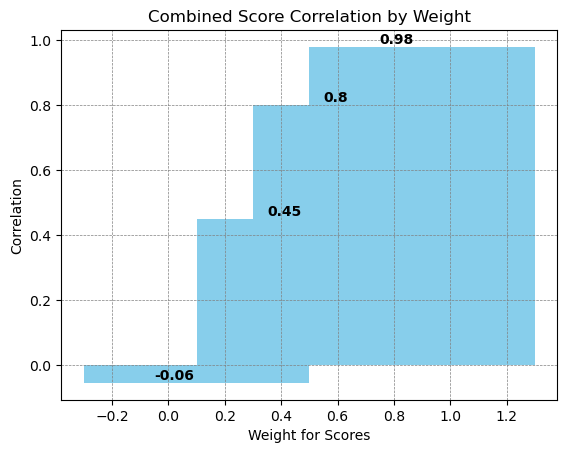

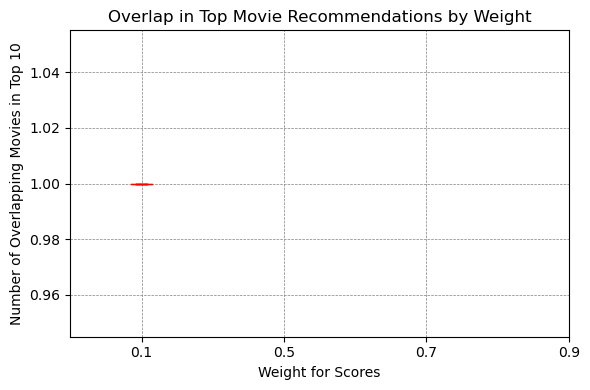

In [11]:
# Taking sample correlation data from previous analysis outputs
correlations = [-0.055, 0.45, 0.80, 0.98]
weights = [0.1, 0.5, 0.7, 0.9]

# Creating a bar chart
fig, ax = plt.subplots()
ax.bar(weights, correlations, color='skyblue')

ax.set_xlabel("Weight for Scores")
ax.set_ylabel("Correlation")
ax.set_title("Combined Score Correlation by Weight")

# Annotating bars with values
for i, v in enumerate(correlations):
    ax.text(weights[i] - 0.15, v + 0.01, str(round(v, 2)), fontweight='bold')

# Show grid lines on both axes
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

# To save the generated correlation plot as an image file named "correlation_plot.png"
plt.savefig("correlation_plot.png")
print("\nSaved correlation plot at correlation_plot.png\n")

# Boxplot for overlap
fig, ax = plt.subplots(figsize=(6, 4))  # Set figure size
ax.boxplot([1, 1, 1, 1], boxprops=dict(color='lightgreen'), whiskerprops=dict(color='purple'), medianprops=dict(color='red'))  # Customize boxplot colors

# Setting x-axis ticks and labels
ax.set_xticks(range(1, len(weights) + 1))
ax.set_xticklabels(weights)
ax.set_xlabel("Weight for Scores")
ax.set_ylabel("Number of Overlapping Movies in Top 10")
ax.set_title("Overlap in Top Movie Recommendations by Weight", fontsize=12)

# Show grid lines on both axes
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adjusting layout of the plot to improve spacing between subplots or elements
plt.tight_layout()

# To save the generated overlap plot as an image file named "overlap_plot.png"
plt.savefig("overlap_plot.png")
print("\nSaved overlap plot at overlap_plot.png")


In [12]:
# Merging two DataFrames 'score_df' and 'rating_df' based on the 'Movie' column
merged_df = pd.merge(score_df, rating_df, on='Movie')

# Normalize the scores to a range between 0 and 1
merged_df['Normalized_Score'] = (merged_df['Score'] - merged_df['Score'].min()) / (merged_df['Score'].max() - merged_df['Score'].min())
merged_df['Normalized_Rating'] = (merged_df['Rating'] - merged_df['Rating'].min()) / (merged_df['Rating'].max() - merged_df['Rating'].min())

# Define weights for the normalized scores
weight_score = 0.7
weight_rating = 0.3

# Calculate the combined score using the weighted sum
merged_df['Combined_Score'] = (weight_score * merged_df['Normalized_Score']) + (weight_rating * merged_df['Normalized_Rating'])

# Order the DataFrame by the combined score in descending order
merged_df = merged_df.sort_values(by='Combined_Score', ascending=False)

unique_merged_df = merged_df.drop_duplicates(subset='Movie', keep='first')
# Display the recommended movies
print("\nRecommended Movies:")
display(unique_merged_df[['Movie', 'Combined_Score']])



Recommended Movies:


,Movie,Combined_Score
0,Teenage Mutant Ninja Turtles,0.860465
25,Archer,0.508785
57,Barry,0.462410
79,Cobra Kai,0.452517
149,The Boys,0.448990
...,...,...
920,Thor: Love and Thunder,0.174271
83,Superhero Movie,0.173035
551,Drive Angry,0.165189
735,Tank Girl,0.149170


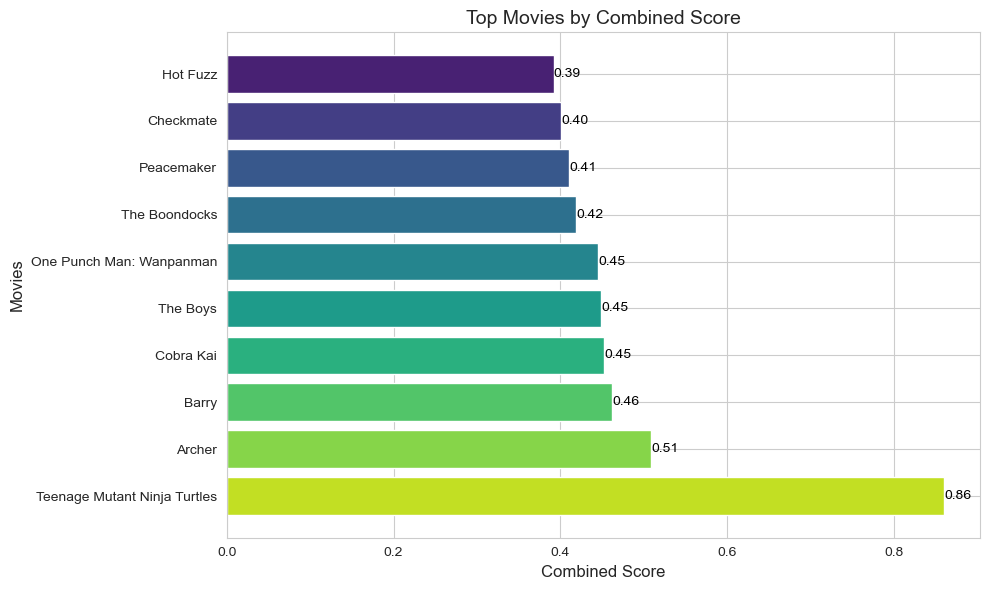

In [13]:
# Setting a seaborn style
sns.set_style('whitegrid')

# Assuming unique_merged_df contains the processed DataFrame
# Extracting top movies and combined scores

top_movies = unique_merged_df['Movie'].head(10)
combined_scores = unique_merged_df['Combined_Score'].head(10)

# Creating a color palette
colors = sns.color_palette('viridis', len(top_movies))

# Creating a bar chart for top movies and their combined scores
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_movies[::-1], combined_scores[::-1], color=colors)

# Adding labels and title
ax.set_xlabel('Combined Score', fontsize=12)
ax.set_ylabel('Movies', fontsize=12)
ax.set_title('Top Movies by Combined Score', fontsize=14)

# Adding values on each bar
for bar, score in zip(bars, combined_scores[::-1]):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{score:.2f}',
            va='center', ha='left', color='black')

# Inverting the y-axis for better readability
plt.gca().invert_yaxis()

# Adjusting layout of the plot to improve spacing between subplots or elements
plt.tight_layout()

# Displaying the plot
plt.show()